<a href="https://colab.research.google.com/github/mamun-av/portfolio-projects/blob/master/Linear_regression_on_medical_charges.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement
ACME Insurance Inc. offers affordable health insurance to thousands of customer all over the United States. As the lead data scientist at ACME, you're tasked with creating an automated system to estimate the annual medical expenditure for new customers, using information such as their age, sex, BMI, children, smoking habits and region of residence.

Estimates from your system will be used to determine the annual insurance premium (amount paid every month) offered to the customer. Due to regulatory requirements, you must be able to explain why your system outputs a certain prediction.

You're given a [CSV](https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv) file containing verified historical data, consisting of the aforementioned information and the actual medical charges incurred by over 1300 customers.

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Downloading the Data

To begin, let's download the data using the `urlretrieve` function from `urllib.request`.

In [3]:
medical_charges_url = 'https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv'

from urllib.request import urlretrieve
urlretrieve(medical_charges_url, 'medical.csv')


('medical.csv', <http.client.HTTPMessage at 0x7fc1ce98b090>)

We can now create a Pandas dataframe using the downloaded file, to view and analyze the data.

In [4]:
!pip install pandas --quiet

In [5]:
import pandas as pd

In [6]:
medical_df = pd.read_csv('medical.csv')
medical_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


The dataset contains 1338 rows and 7 columns. Each row of the dataset contains information about one customer. 

Our objective is to find a way to estimate the value in the "charges" column using the values in the other columns. If we can do so for the historical data, then we should able to estimate charges for new customers too, simply by asking for information like their age, sex, BMI, no. of children, smoking habits and region.

Let's check the data type for each column.

In [7]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Looks like "age", "children", "bmi" ([body mass index](https://en.wikipedia.org/wiki/Body_mass_index)) and "charges" are numbers, whereas "sex", "smoker" and "region" are strings (possibly categories). None of the columns contain any missing values, which saves us a fair bit of work!

Here are some statistics for the numerical columns:

In [8]:
medical_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The ranges of values in the numerical columns seem reasonable too (no negative ages!), so we may not have to do much data cleaning or correction. The "charges" column seems to be significantly skewed however, as the median (50 percentile) is much lower than the maximum value.


> **EXERCISE**: What other inferences can you draw by looking at the table above? Add your inferences below:
>
> 1. Age ranges from 18-64.
> 2. chages vary a lot from min to max.



## Exploratory Analysis and Visualization

Let's explore the data by visualizing the distribution of values in some columns of the dataset, and the relationships between "charges" and other columns.

We'll use libraries Matplotlib, Seaborn and Plotly for visualization. Follow these tutorials to learn how to use these libraries: 

- https://jovian.ai/aakashns/python-matplotlib-data-visualization
- https://jovian.ai/aakashns/interactive-visualization-plotly
- https://jovian.ai/aakashns/dataviz-cheatsheet

The following settings will improve the default style and font sizes for our charts. only for matplotlib and seaborn

In [9]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Age

Age is a numeric column. The minimum age in the dataset is 18 and the maximum age is 64. Thus, we can visualize the distribution of age using a histogram with 47 bins (one for each year) and a box plot. We'll use plotly to make the chart interactive, but you can create similar charts using Seaborn.

In [10]:
medical_df.age.describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

In [11]:
fig = px.histogram(medical_df, 
                   x='age', 
                   marginal='box', 
                   nbins=47, 
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

The distribution of ages in the dataset is almost uniform, with 20-30 customers at every age, except for the ages 18 and 19, which seem to have over twice as many customers as other ages. The uniform distribution might arise from the fact that there isn't a big variation in the [number of people of any given age](https://www.statista.com/statistics/241488/population-of-the-us-by-sex-and-age/) (between 18 & 64) in the USA.



> **EXERCISE**: Can you explain why there are over twice as many customers with ages 18 and 19, compared to other ages?
>
> May be insurance company offering lower premium for young people during age 18-19.

> As 18 is the least age to become a member , so they just sign in when turns into 18.

### Body Mass Index

Let's look at the distribution of BMI (Body Mass Index) of customers, using a histogram and box plot.

In [12]:
fig = px.histogram(medical_df, 
                   x='bmi', 
                   marginal='box', 
                   color_discrete_sequence=['red'], 
                   title='Distribution of BMI (Body Mass Index)')
fig.update_layout(bargap=0.1)
fig.show()

The measurements of body mass index seem to form a [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) centered around the value 30, with a few outliers towards the right. Here's how BMI values can be interpreted ([source](https://study.com/academy/lesson/what-is-bmi-definition-formula-calculation.html)):

![](https://i.imgur.com/lh23OiY.jpg)

> **EXERCISE**: Can you explain why the distribution of ages forms a uniform distribution while the distribution of BMIs forms a gaussian distribution?
>
> The number of people in different ages are very close to each other, there was no high variation in numbers, so it formed uniform distribution whereas in BMI forms gausian distribution because majority of people BMI ranges fall close to center(mean) and apart form mean the number is decreasing both side from the centre, so its bell shape ,or gaussian dist.

### Charges with smoker group

Let's visualize the distribution of "charges" i.e. the annual medical charges for customers. This is the column we're trying to predict. Let's also use the categorical column "smoker" to distinguish the charges for smokers and non-smokers.

In [13]:
fig = px.histogram(medical_df, 
                   x='charges', 
                   marginal='box', 
                   color='smoker', 
                   color_discrete_sequence=['green', 'grey'], 
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

We can make the following observations from the above graph:

* For most customers, the annual medical charges are under \\$10,000. Only a small fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases. The distribution follows a "power law"
* There is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is \\$7300, the median for smokers is close to \\$35,000.


> **EXERCISE**: Visualize the distribution of medical charges in connection with other factors like "sex" and "region". What do you observe?


# Charges with sex group

In [14]:
fig = px.histogram(medical_df, 
                   x='charges', 
                   marginal='box', 
                   color='sex', 
                   color_discrete_sequence=['green', 'red'], 
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

# Charges with region

In [15]:
fig = px.histogram(medical_df, 
                   x='charges', 
                   marginal='box', 
                   color='region', 
                   color_discrete_sequence=['red', 'blue', 'yellow', 'green'], 
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

Only few number of People charges high over 22k.

### Smoker

Let's visualize the distribution of the "smoker" column (containing values "yes" and "no") using a histogram.

In [16]:
medical_df.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [17]:
px.histogram(medical_df, x='smoker', color='sex', title='Smoker')

It appears that 20% of customers have reported that they smoke. Can you verify whether this matches the national average, assuming the data was collected in 2010? We can also see that smoking appears a more common habit among males. Can you verify this?
> **EXERCISE**: Visualize the distributions of the "sex", "region" and "children" columns and report your observations. 

In [18]:
# SEX
medical_df.sex.value_counts()

male      676
female    662
Name: sex, dtype: int64

In [19]:
px.histogram(medical_df, x='sex', color='smoker', title='Smoker')

In [20]:
# Region
medical_df.region.value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

In [21]:
px.histogram(medical_df, x='region', color='smoker', title='Smoker')

In [22]:
# Children
medical_df.children.value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

In [23]:
px.histogram(medical_df, x='children', color='region', title='Smoker')

Every region has the almost same distribution of children.

Having looked at individual columns, we can now visualize the relationship between "charges" (the value we wish to predict) and other columns.

### Age and Charges

Let's visualize the relationship between "age" and "charges" using a scatter plot. Each point in the scatter plot represents one customer. We'll also use values in the "smoker" column to color the points.

In [24]:
fig = px.scatter(medical_df, 
                 x='age', 
                 y='charges', 
                 color='smoker', 
                 opacity=0.8, 
                 hover_data=['sex'], 
                 title='Age vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

We can make the following observations from the above chart:

* The general trend seems to be that medical charges increase with age, as we might expect. However, there is significant variation at every age, and it's clear that age alone cannot be used to accurately determine medical charges.


* We can see three "clusters" of points, each of which seems to form a line with an increasing slope:

     1. The first and the largest cluster consists primary of presumably "healthy non-smokers" who have relatively low medical charges compared to others
     
     2. The second cluster contains a mix of smokers and non-smokers. It's possible that these are actually two distinct but overlapping clusters: "non-smokers with medical issues" and "smokers without major medical issues".
     
     3. The final cluster consists exclusively of smokers, presumably smokers with major medical issues that are possibly related to or worsened by smoking.
     

### BMI and Charges

Let's visualize the relationship between BMI (body mass index) and charges using another scatter plot. Once again, we'll use the values from the "smoker" column to color the points.

In [25]:
fig = px.scatter(medical_df, 
                 x='bmi', 
                 y='charges', 
                 color='smoker', 
                 opacity=0.8, 
                 hover_data=['sex'], 
                 title='BMI vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

It appears that for non-smokers, an increase in BMI doesn't seem to be related to an increase in medical charges. However, medical charges seem to be significantly higher for smokers with a BMI greater than 30.

> Smokers have to pay higher charge without affecting bmi.

> **EXERCISE**: Create some more graphs to visualize how the "charges" column is related to other columns ("children", "sex", "region" and "smoker"). Summarize the insights gathered from these graphs.
>
> *Hint*: Use violin plots (`px.violin`) and bar plots (`sns.barplot`)

In [88]:
px.violin(medical_df, 
                 x='children', 
                 y='charges',
          title = "charges vs no.of children")

This violon plot describes about the number of children varies on charges, more wider plot means more number of people and flatten means less frequency. So, people who have 5 children their numbers are high though they pay less charges. The charges amount is not changing with increasing children numbers. Compare from those who have no children and who has more than 4 children pay more charges becasue they may have other diseases, so their charges is high.

In [90]:
px.violin(medical_df, 
                 x='sex', 
                 y='charges',
          title = "charges vs sex")

More females have to pay high charges compare to men.

In [95]:
px.violin(medical_df, 
                 x='region', 
                 y='charges',
          title = "charges vs region")

In [97]:
px.box(medical_df, 
                 x='smoker', 
                 y='charges',
          title = "charges vs smoker")

### Correlation

As you can tell from the analysis, the values in some columns are more closely related to the values in "charges" compared to other columns. E.g. "age" and "charges" seem to grow together, whereas "bmi" and "charges" don't.

This relationship is often expressed numerically using a measure called the _correlation coefficient_, which can be computed using the `.corr` method of a Pandas series.

In [26]:
medical_df.charges.corr(medical_df.age)

0.2990081933306476

In [27]:
medical_df.charges.corr(medical_df.bmi)

0.19834096883362895

In [98]:
medical_df.charges.corr(medical_df.children)

0.06799822684790478

To compute the correlation for categorical columns, they must first be converted into numeric columns.

In [99]:
medical_df.smoker

0       yes
1        no
2        no
3        no
4        no
       ... 
1333     no
1334     no
1335     no
1336     no
1337    yes
Name: smoker, Length: 1338, dtype: object

In [103]:
smoker_values = {'no': 0, 'yes': 1}
smoker_numeric = medical_df.smoker.map(smoker_values)
print(smoker_numeric)
print("correlation between charges with smoker\n:")
medical_df.charges.corr(smoker_numeric)

0       1
1       0
2       0
3       0
4       0
       ..
1333    0
1334    0
1335    0
1336    0
1337    1
Name: smoker, Length: 1338, dtype: int64
correlation between charges with smoker
:


0.787251430498478

In [29]:
medical_df.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


The result of `.corr` is called a correlation matrix and is often visualized using a heatmap.

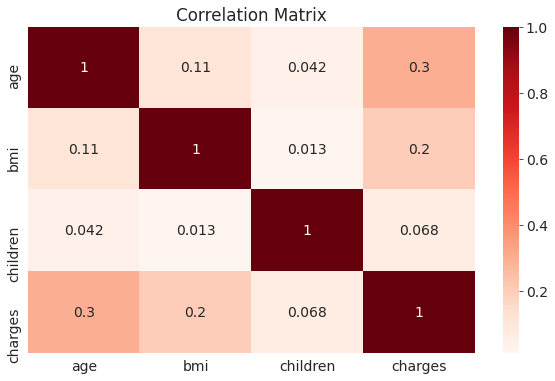

In [30]:
sns.heatmap(medical_df.corr(), cmap='Reds', annot=True)
plt.title('Correlation Matrix');

**Correlation vs causation fallacy:** Note that a high correlation cannot be used to interpret a cause-effect relationship between features. Two features $X$ and $Y$ can be correlated if $X$ causes $Y$ or if $Y$ causes $X$, or if both are caused independently by some other factor $Z$, and the correlation will no longer hold true if one of the cause-effect relationships is broken. It's also possible that $X$ are $Y$ simply appear to be correlated because the sample is too small. 

While this may seem obvious, computers can't differentiate between correlation and causation, and decisions based on automated system can often have major consequences on society, so it's important to study why automated systems lead to a given result. Determining cause-effect relationships requires human insight.

## Linear Regression using a Single Feature

We now know that the "smoker" and "age" columns have the strongest correlation with "charges". Let's try to find a way of estimating the value of "charges" using the value of "age" for non-smokers. First, let's create a data frame containing just the data for non-smokers.

In [31]:
non_smoker_df = medical_df[medical_df.smoker == 'no']

Next, let's visualize the relationship between "age" and "charges"

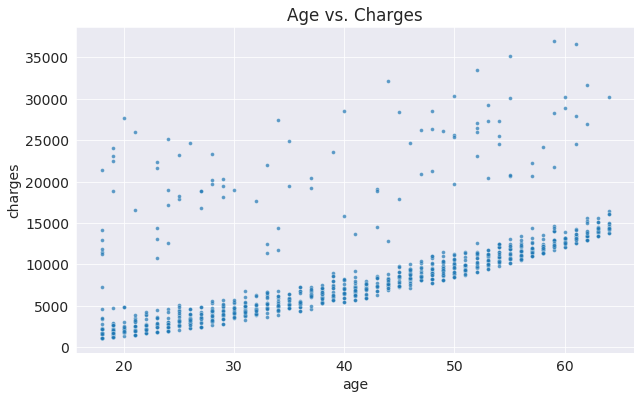

In [32]:
plt.title('Age vs. Charges')
sns.scatterplot(data=non_smoker_df, x='age', y='charges', alpha=0.7, s=15);

Apart from a few exceptions, the points seem to form a line. We'll try and "fit" a line using this points, and use the line to predict charges for a given age. A line on the X&Y coordinates has the following formula:

$y = wx + b$

The line is characterized two numbers: $w$ (called "slope") and $b$ (called "intercept"). 

### Model

In the above case, the x axis shows "age" and the y axis shows "charges". Thus, we're assume the following relationship between the two:

$charges = w \times age + b$

We'll try determine $w$ and $b$ for the line that best fits the data. 

* This technique is called _linear regression_, and we call the above equation a _linear regression model_, because it models the relationship between "age" and "charges" as a straight line. 

* The numbers $w$ and $b$ are called the _parameters_ or _weights_ of the model.

* The values in the "age" column of the dataset are called the _inputs_ to the model and the values in the charges column are called "targets". 

Let define a helper function `estimate_charges`, to compute $charges$, given $age$, $w$ and $b$.

In [33]:
def estimate_charges(age, w, b):
    return w * age + b

The `estimate_charges` function is our very first _model_.

Let's _guess_ the values for $w$ and $b$ and use them to estimate the value for charges.

In [34]:
w = 50
b = 100

In [106]:
ages = non_smoker_df.age
print(ages)
estimated_charges = estimate_charges(ages, w, b)
print(estimated_charges)
print("actual charges: ", non_smoker_df.charges)

1       18
2       28
3       33
4       32
5       31
        ..
1332    52
1333    50
1334    18
1335    18
1336    21
Name: age, Length: 1064, dtype: int64
1       1000
2       1500
3       1750
4       1700
5       1650
        ... 
1332    2700
1333    2600
1334    1000
1335    1000
1336    1150
Name: age, Length: 1064, dtype: int64
actual charges:  1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
5        3756.62160
           ...     
1332    11411.68500
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
Name: charges, Length: 1064, dtype: float64


In [107]:
# difference between actual charges and estimated charges with w=50 and b = 100
diff = (non_smoker_df.charges)-(estimated_charges)
diff

1         725.55230
2        2949.46200
3       20234.47061
4        2166.85520
5        2106.62160
           ...     
1332     8711.68500
1333     8000.54830
1334     1205.98080
1335      629.83350
1336      857.94500
Length: 1064, dtype: float64

We can plot the estimated charges using a line graph.

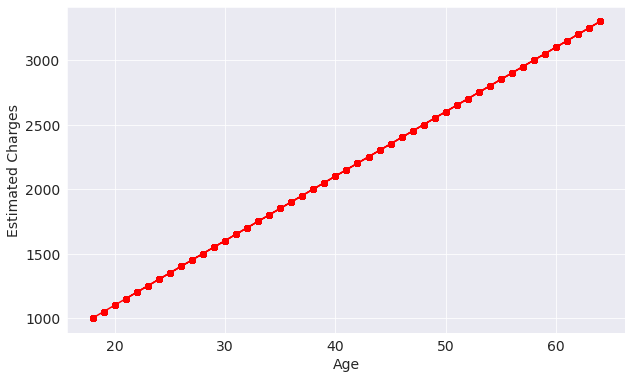

In [36]:
plt.plot(ages, estimated_charges, 'r-o');
plt.xlabel('Age');
plt.ylabel('Estimated Charges');

As expected, the points lie on a straight line. 

We can overlay this line on the actual data, so see how well our _model_ fits the _data_.

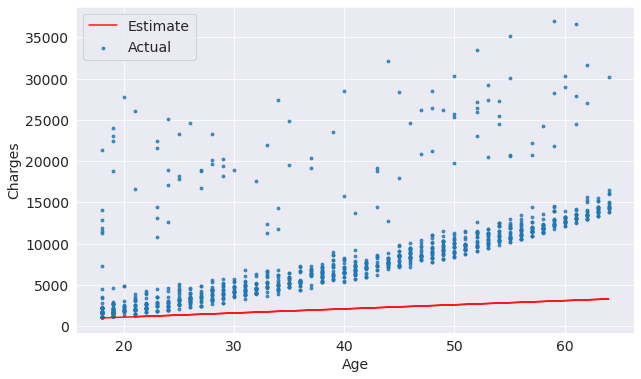

In [37]:
target = non_smoker_df.charges

plt.plot(ages, estimated_charges, 'r', alpha=0.9);
plt.scatter(ages, target, s=8,alpha=0.8);
plt.xlabel('Age');
plt.ylabel('Charges')
plt.legend(['Estimate', 'Actual']);

Clearly, the our estimates are quite poor and the line does not "fit" the data. However, we can try different values of $w$ and $b$ to move the line around. Let's define a helper function `try_parameters` which takes `w` and `b` as inputs and creates the above plot.

In [38]:
def try_parameters(w, b):
    ages = non_smoker_df.age
    target = non_smoker_df.charges
    
    estimated_charges = estimate_charges(ages, w, b)
    
    plt.plot(ages, estimated_charges, 'r', alpha=0.9);
    plt.scatter(ages, target, s=8,alpha=0.8);
    plt.xlabel('Age');
    plt.ylabel('Charges')
    plt.legend(['Estimate', 'Actual']);

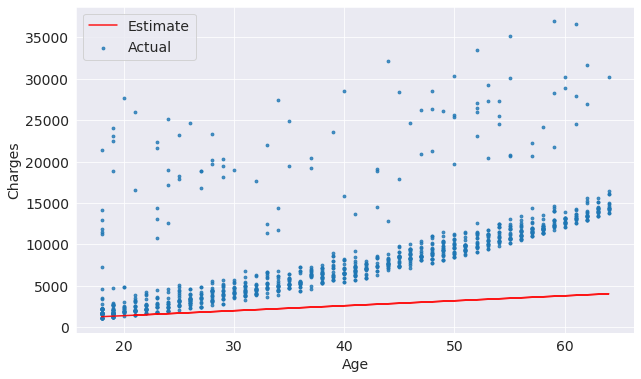

In [39]:
try_parameters(60,200)

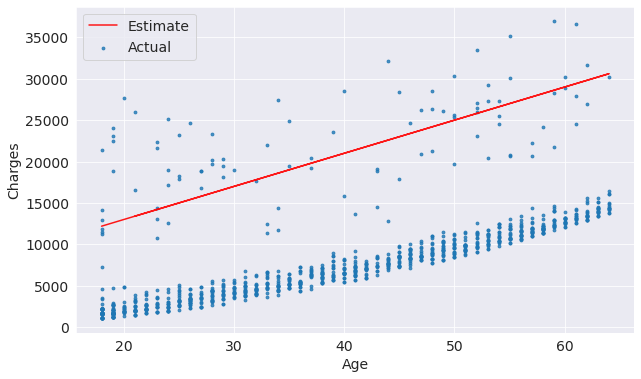

In [40]:
try_parameters(400, 5000)

As we change the values, of $w$ and $b$ manually, trying to move the line visually closer to the points, we are _learning_ the approximate relationship between "age" and "charges". 

Wouldn't it be nice if a computer could try several different values of `w` and `b` and _learn_ the relationship between "age" and "charges"? To do this, we need to solve a couple of problems:

1. We need a way to measure numerically how well the line fits the points.

2. Once the "measure of fit" has been computed, we need a way to modify `w` and `b` to improve the the fit.

If we can solve the above problems, it should be possible for a computer to determine `w` and `b` for the best fit line, starting from a random guess.

### Loss/Cost Function

We can compare our model's predictions with the actual targets using the following method:

* Calculate the difference between the targets and predictions (the differenced is called the "residual")
* Square all elements of the difference matrix to remove negative values.
* Calculate the average of the elements in the resulting matrix.
* Take the square root of the result

The result is a single number, known as the **root mean squared error** (RMSE). The above description can be stated mathematically as follows: 

<img src="https://i.imgur.com/WCanPkA.png" width="360">

Geometrically, the residuals can be visualized as follows:

<img src="https://i.imgur.com/ll3NL80.png" width="420">

Let's define a function to compute the RMSE.

In [41]:
def rmse(targets, predictions):
    return np.sqrt(np.mean(np.square(targets - predictions)))

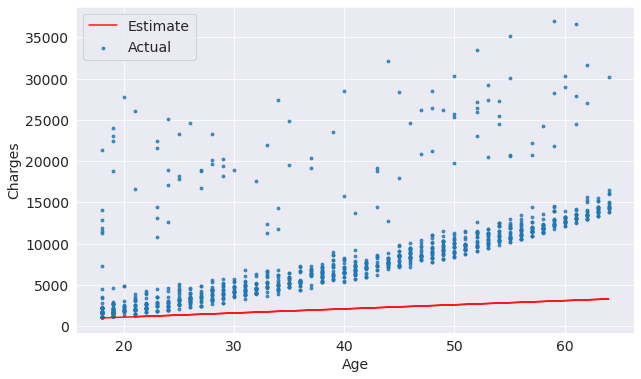

In [42]:
# Let's compute the RMSE for our model with a sample set of weights
w = 50
b = 100
try_parameters(w, b)

In [43]:
targets = non_smoker_df['charges']
predicted = estimate_charges(non_smoker_df.age, w, b)

In [44]:
rmse(targets, predicted)

8461.949562575488

Here's how we can interpret the above number: *On average, each element in the prediction differs from the actual target by \\$8461*. 

The result is called the *loss* because it indicates how bad the model is at predicting the target variables. It represents information loss in the model: the lower the loss, the better the model.

Let's modify the `try_parameters` functions to also display the loss.

In [45]:
def try_parameters(w, b):
    ages = non_smoker_df.age
    target = non_smoker_df.charges
    predictions = estimate_charges(ages, w, b)
    
    plt.plot(ages, predictions, 'r', alpha=0.9);
    plt.scatter(ages, target, s=8,alpha=0.8);
    plt.xlabel('Age');
    plt.ylabel('Charges')
    plt.legend(['Prediction', 'Actual']);
    
    loss = rmse(target, predictions)
    print("RMSE Loss: ", loss)

RMSE Loss:  8461.949562575488


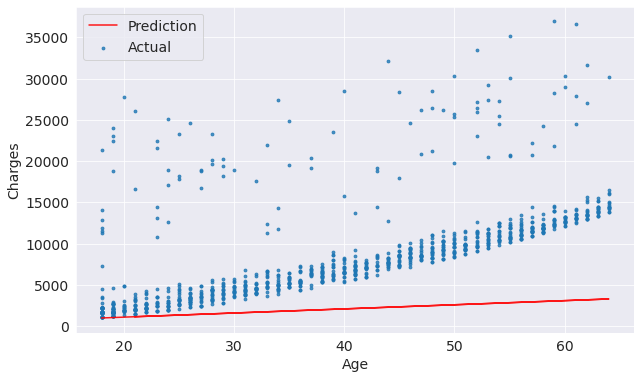

In [46]:
try_parameters(50, 100)

> **EXERCISE**: Try different values of $w$ and $b$ to minimize the RMSE loss. What's the lowest value of loss you are able to achieve? Can you come with a general strategy for finding better values of $w$ and $b$ by trial and error?

RMSE Loss:  4662.5165244874015


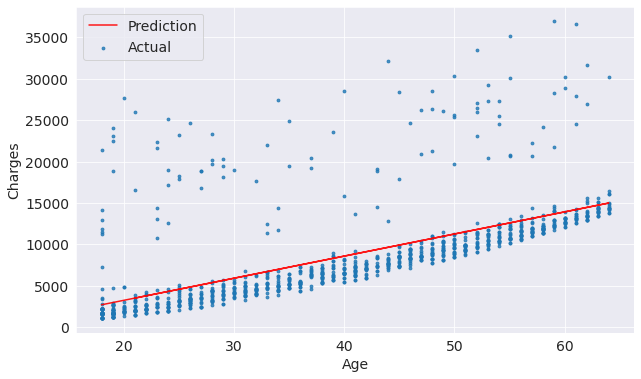

In [47]:
try_parameters(267, -2091)

### Optimizer

Next, we need a strategy to modify weights `w` and `b` to reduce the loss and improve the "fit" of the line to the data.

* Ordinary Least Squares: https://www.youtube.com/watch?v=szXbuO3bVRk (better for smaller datasets)
* Stochastic gradient descent: https://www.youtube.com/watch?v=sDv4f4s2SB8 (better for larger datasets)

Both of these have the same objective: to minimize the loss, however, while ordinary least squares directly computes the best values for `w` and `b` using matrix operations, while gradient descent uses a iterative approach, starting with a random values of `w` and `b` and slowly improving them using derivatives. 

Here's a visualization of how gradient descent works:

![](https://miro.medium.com/max/1728/1*NO-YvpHHadk5lLxtg4Gfrw.gif)

Doesn't it look similar to our own strategy of gradually moving the line closer to the points?


### Linear Regression using Scikit-learn

In practice, you'll never need to implement either of the above methods yourself. You can use a library like `scikit-learn` to do this for you. 

In [110]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Next, we can use the `fit` method of the model to find the best fit line for the inputs and targets.


In [111]:
help(model.fit)

Help on method fit in module sklearn.linear_model._base:

fit(X, y, sample_weight=None) method of sklearn.linear_model._base.LinearRegression instance
    Fit linear model.
    
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Training data
    
    y : array-like of shape (n_samples,) or (n_samples, n_targets)
        Target values. Will be cast to X's dtype if necessary
    
    sample_weight : array-like of shape (n_samples,), default=None
        Individual weights for each sample
    
        .. versionadded:: 0.17
           parameter *sample_weight* support to LinearRegression.
    
    Returns
    -------
    self : returns an instance of self.



__Note__ that the input `X` must be a 2-d array, so we'll need to pass a dataframe, instead of a single column.

In [112]:
inputs = non_smoker_df[['age']]
targets = non_smoker_df.charges
print('inputs.shape :', inputs.shape)
print('targes.shape :', targets.shape)

inputs.shape : (1064, 1)
targes.shape : (1064,)


Let's fit the model to the data.

In [113]:
model.fit(inputs, targets)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

We can now make predictions using the model. Let's try predicting the charges for the ages 23, 37 and 61

In [114]:
model.predict(np.array([[23], 
                        [37], 
                        [61]]))

array([ 4055.30443855,  7796.78921819, 14210.76312614])

Do these values seem reasonable? Compare them with the scatter plot above.

Let compute the predictions for the entire set of inputs

In [115]:
predictions = model.predict(inputs)
predictions

array([2719.0598744 , 5391.54900271, 6727.79356686, ..., 2719.0598744 ,
       2719.0598744 , 3520.80661289])

Let's compute the RMSE loss to evaluate the model.

In [116]:
rmse(targets, predictions)

4662.505766636391

Seems like our prediction is off by $4000 on average, which is not too bad considering the fact that there are several outliers.

The parameters of the model are stored in the `coef_` and `intercept_` properties.

In [117]:
# w
model.coef_

array([267.24891283])

In [118]:
# b
model.intercept_

-2091.4205565650864

Are these parameters close to your best guesses?

Let's visualize the line created by the above parameters.

RMSE Loss:  4662.505766636391


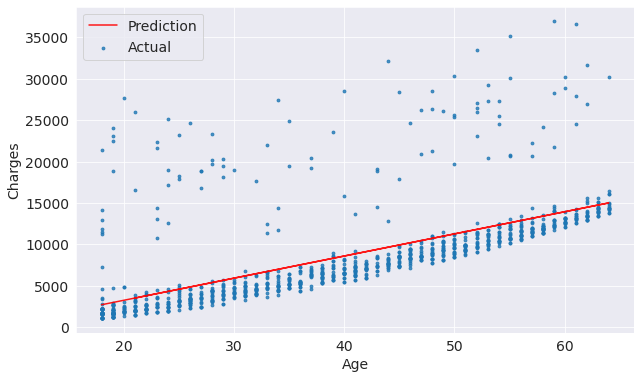

In [119]:
try_parameters(model.coef_, model.intercept_)

Indeed the line is quite close to the points. It is slightly above the cluster of points, because it's also trying to account for the outliers. 

> **EXERCISE**: Use the [`SGDRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) class from `scikit-learn` to train a model using the stochastic gradient descent technique. Make predictions and compute the loss. Do you see any difference in the result?

In [120]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor()
sgd.fit(inputs, targets)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [121]:
pred = sgd.predict(inputs)

In [122]:
rmse(targets, pred)

5396.511301243477

RMSE Loss:  5396.511301243477


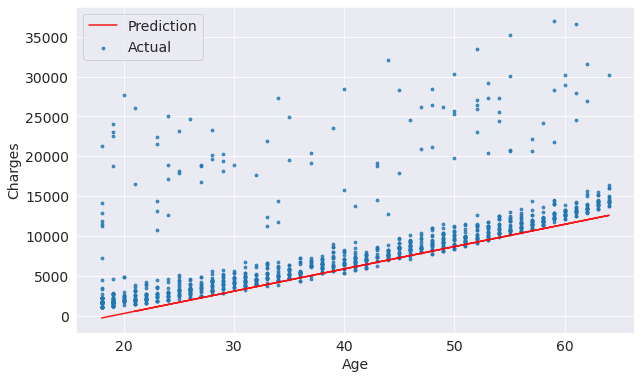

In [123]:
try_parameters(sgd.coef_, sgd.intercept_)

> **EXERCISE**: Repeat the steps is this section to train a linear regression model to estimate medical charges for smokers. Visualize the targets and predictions, and compute the loss.

In [124]:
smoker_df = medical_df[medical_df.smoker == "yes"]
inputs1 = smoker_df[["age"]]
targets1 = smoker_df.charges
print('inputs.shape :', inputs1.shape)
print('targes.shape :', targets1.shape)

inputs.shape : (274, 1)
targes.shape : (274,)


In [125]:
model1 = LinearRegression()

In [126]:
model1.fit(inputs1, targets1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [127]:
pred1 = model1.predict(inputs1)

In [128]:
rmse(targets1, pred1)

10711.00334810241

RMSE Loss:  24338.50287259921


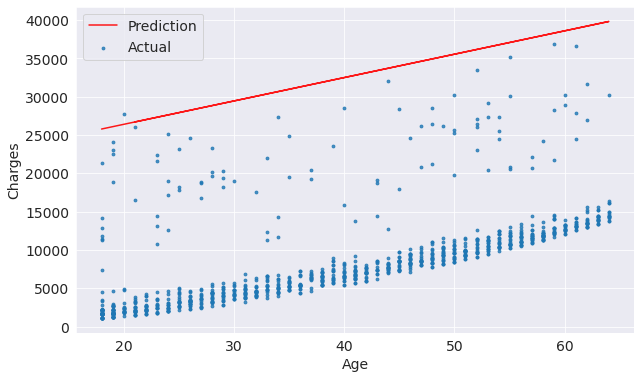

In [129]:
try_parameters(model1.coef_, model1.intercept_)

### Machine Learning

Congratulations, you've just trained your first _machine learning model!_ Machine learning is simply the process of computing the best parameters to model the relationship between some feature and targets. 

Every machine learning problem has three components:

1. **Model**

2. **Cost Function**

3. **Optimizer**

We'll look at several examples of each of the above in future tutorials. Here's how the relationship between these three components can be visualized:

<img src="https://www.deepnetts.com/blog/wp-content/uploads/2019/02/SupervisedLearning.png" width="480">

As we've seen above, it takes just a few lines of code to train a machine learning model using `scikit-learn`.

In [130]:
# Create inputs and targets
inputs, targets = non_smoker_df[['age']], non_smoker_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 4662.505766636391


In [131]:
# Create inputs and targets
inputs, targets = smoker_df[['age']], smoker_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 10711.00334810241


## Linear Regression using Multiple Features

So far, we've used on the "age" feature to estimate "charges". Adding another feature like "bmi" is fairly straightforward. We simply assume the following relationship:

$charges = w_1 \times age + w_2 \times bmi + b$

We need to change just one line of code to include the BMI.

In [132]:
# Create inputs and targets
inputs, targets = non_smoker_df[['age', 'bmi']], non_smoker_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 4662.312835461298


As you can see, adding the BMI doesn't seem to reduce the loss by much, as the BMI has a very weak correlation with charges, especially for non smokers.

In [133]:
non_smoker_df.charges.corr(non_smoker_df.bmi)

0.08403654312833268

In [134]:
fig = px.scatter(non_smoker_df, x='bmi', y='charges', title='BMI vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

We can also visualize the relationship between all 3 variables "age", "bmi" and "charges" using a 3D scatter plot.

In [135]:
fig = px.scatter_3d(non_smoker_df, x='age', y='bmi', z='charges')
fig.update_traces(marker_size=3, marker_opacity=0.5)
fig.show()

You can see that it's harder to interpret a 3D scatter plot compared to a 2D scatter plot. As we add more features, it becomes impossible to visualize all feature at once, which is why we use measures like correlation and loss. 

Let's also check the parameters of the model.

In [136]:
model.coef_, model.intercept_

(array([266.87657817,   7.07547666]), -2293.6320906488727)

Clearly, BMI has a much lower weightage, and you can see why. It has a tiny contribution, and even that is probably accidental. This is an important thing to keep in mind: you can't find a relationship that doesn't exist, no matter what machine learning technique or optimization algorithm you apply. 

> **EXERCISE**: Train a linear regression model to estimate charges using BMI alone. Do you expect it to be better or worse than the previously trained models?

In [137]:
# Create inputs and targets
inputs, targets = non_smoker_df[['bmi']], non_smoker_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 5969.772531913287


Let's go one step further, and add the final numeric column: "children", which seems to have some correlation with "charges".

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + b$

In [138]:
non_smoker_df.charges.corr(non_smoker_df.children)

0.13892870453542194

In [139]:
fig = px.strip(non_smoker_df, x='children', y='charges', title= "Children vs. Charges")
fig.update_traces(marker_size=4, marker_opacity=0.7)
fig.show()

In [140]:
# Create inputs and targets
inputs, targets = non_smoker_df[['age', 'bmi', 'children']], non_smoker_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 4608.470405038245


Once again, we don't see a big reduction in the loss, even though it's greater than in the case of BMI.

> **EXERCISE**: Repeat the steps is this section to train a linear regression model to estimate medical charges for smokers. Visualize the targets and predictions, and compute the loss.

In [141]:
# Create inputs and targets
inputs, targets = smoker_df[['age', 'bmi', 'children']], smoker_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 5718.202480524153


> **EXERCISE**: Repeat the steps is this section to train a linear regression model to estimate medical charges for all customers. Visualize the targets and predictions, and compute the loss. Is the loss lower or higher?

In [142]:
# Create inputs and targets
inputs, targets = medical_df[['age', 'bmi', 'children']], medical_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 11355.317901125969


## Using Categorical Features for Machine Learning

So far we've been using only numeric columns, since we can only perform computations with numbers. If we could use categorical columns like "smoker", we can train a single model for the entire dataset.

To use the categorical columns, we simply need to convert them to numbers. There are three common techniques for doing this:

1. If a categorical column has just two categories (it's called a binary category), then we can replace their values with 0 and 1.
2. If a categorical column has more than 2 categories, we can perform one-hot encoding i.e. create a new column for each category with 1s and 0s.
3. If the categories have a natural order (e.g. cold, neutral, warm, hot), then they can be converted to numbers (e.g. 1, 2, 3, 4) preserving the order. These are called ordinals



## Binary Categories

The "smoker" category has just two values "yes" and "no". Let's create a new column "smoker_code" containing 0 for "no" and 1 for "yes".

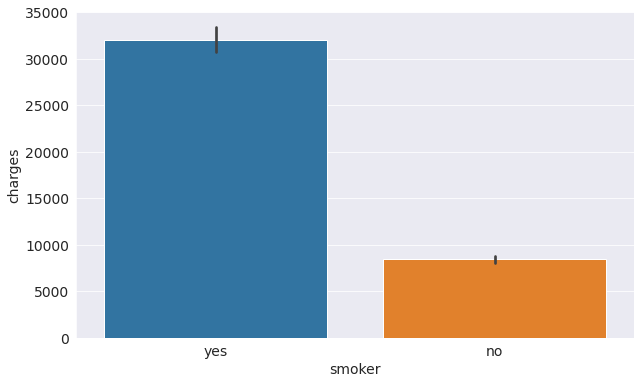

In [143]:
sns.barplot(data=medical_df, x='smoker', y='charges');

In [144]:
smoker_codes = {'no': 0, 'yes': 1}
medical_df['smoker_code'] = medical_df.smoker.map(smoker_codes)

In [145]:
medical_df.charges.corr(medical_df.smoker_code)

0.787251430498478

In [146]:
medical_df.head()

,age,sex,bmi,children,smoker,region,charges,smoker_code
0,19,female,27.900,0,yes,southwest,16884.92400,1
1,18,male,33.770,1,no,southeast,1725.55230,0
2,28,male,33.000,3,no,southeast,4449.46200,0
3,33,male,22.705,0,no,northwest,21984.47061,0
4,32,male,28.880,0,no,northwest,3866.85520,0


We can now use the `smoker_df` column for linear regression.

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + b$

In [147]:
# Create inputs and targets
inputs, targets = medical_df[['age', 'bmi', 'children', 'smoker_code']], medical_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6056.439217188077


The loss reduces from `11355` to `6056`, almost by 50%! This is an important lesson: never ignore categorical data.


Let's try adding the "sex" column as well.

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + w_5 \times sex + b$

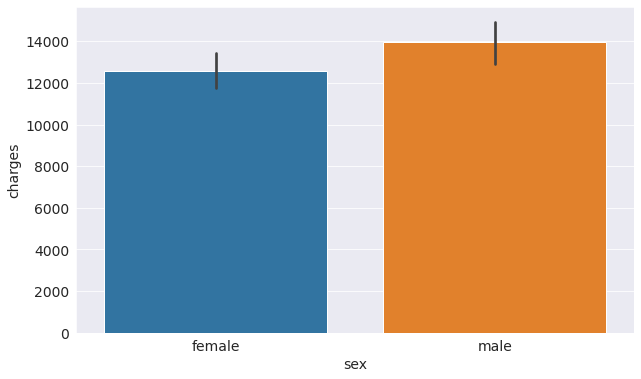

In [148]:
sns.barplot(data=medical_df, x='sex', y='charges');

In [149]:
sex_codes = {'female': 0, 'male': 1}
medical_df['sex_code'] = medical_df.sex.map(sex_codes)
# Correlation between sex and charges
medical_df.charges.corr(medical_df.sex_code)

0.057292062202025484

In [150]:
# Create inputs and targets
inputs, targets = medical_df[['age', 'bmi', 'children', 'smoker_code', 'sex_code']], medical_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6056.100708754539


As you might expect, this does have a significant impact on the loss.

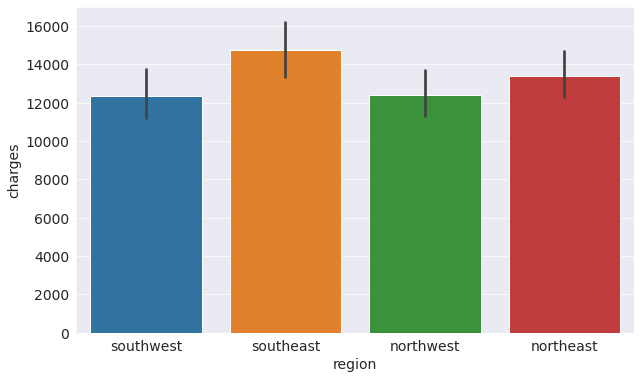

In [151]:
# For region column
sns.barplot(data=medical_df, x='region', y='charges');

In [152]:
from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()
enc.fit(medical_df[['region']])
enc.categories_

[array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

In [153]:
one_hot = enc.transform(medical_df[['region']]).toarray()
one_hot

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [156]:
medical_df[['northeast', 'northwest', 'southeast', 'southwest']] = one_hot

In [168]:
medical_df.head()

,age,sex,bmi,children,smoker,region,charges,smoker_code,sex_code,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0.0,0.0,0.0,1.0
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,0,1,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,0,1,0.0,1.0,0.0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,0.0,1.0,0.0,0.0


Let's include the region columns into our linear regression model.

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + w_5 \times sex + w_6 \times region + b$

In [158]:
# Create inputs and targets
input_cols = ['age', 'bmi', 'children', 'smoker_code', 'sex_code', 'northeast', 'northwest', 'southeast', 'southwest']
inputs, targets = medical_df[input_cols], medical_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6041.679651174453


Once again, this leads to a fairly small reduction in the loss. 

> **EXERCISE**: Are two separate linear regression models, one for smokers and one of non-smokers, better than a single linear regression model? Why or why not? Try it out and see if you can justify your answer with data.

Answer: Its because there is imbalanced data, there is more smoker than non smoker and also have outlier which affect the prediction accurately.

## Model Improvements

Let's discuss and apply some more improvements to our model.

### Feature Scaling

Recall that due to regulatory requirements, we also need to explain the rationale behind the predictions our model. 

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + w_5 \times sex + w_6 \times region + b$

To compare the importance of each feature in the model, our first instinct might be to compare their weights. 

In [159]:
model.coef_

array([  256.85635254,   339.19345361,   475.50054515, 23848.53454191,
        -131.3143594 ,   587.00923503,   234.0453356 ,  -448.01281436,
        -373.04175627])

In [160]:
model.intercept_

-12525.547811195444

In [166]:
# to vie the one specific customer information
medical_df[input_cols].loc[10]

age            25.00
bmi            26.22
children        0.00
smoker_code     0.00
sex_code        1.00
northeast       1.00
northwest       0.00
southeast       0.00
southwest       0.00
Name: 10, dtype: float64

In [171]:
# based on his above information we can predict the charges for him
model.predict([[25,26.22, 0, 0, 1, 1,0,0,0]])

array([3245.20823155])

Based on customer information we got insurance charge for him 3245.20 $ on prediction from model.

In [161]:
weights_df = pd.DataFrame({
    'feature': np.append(input_cols, 1),
    'weight': np.append(model.coef_, model.intercept_)
})
weights_df

,feature,weight
0,age,256.856353
1,bmi,339.193454
2,children,475.500545
3,smoker_code,23848.534542
4,sex_code,-131.314359
5,northeast,587.009235
6,northwest,234.045336
7,southeast,-448.012814
8,southwest,-373.041756
9,1,-12525.547811


While it seems like BMI and the "northeast" have a higher weight than age, keep in mind that the range of values for BMI is limited (15 to 40) and the "northeast" column only takes the values 0 and 1.

Because different columns have different ranges, we run into two issues:

1. We can't compare the weights of different column to identify which features are important
2. A column with a larger range of inputs may disproportionately affect the loss and dominate the optimization process.

For this reason, it's common practice to scale (or standardize) the values in numeric column by subtracting the mean and dividing by the standard deviation.

![](https://i.imgur.com/dT5fLFI.png)

We can apply scaling using the StandardScaler class from `scikit-learn`.

In [172]:
medical_df

,age,sex,bmi,children,smoker,region,charges,smoker_code,sex_code,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0.0,0.0,0.0,1.0
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,0,1,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,0,1,0.0,1.0,0.0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0,1,0.0,1.0,0.0,0.0
1334,18,female,31.920,0,no,northeast,2205.98080,0,0,1.0,0.0,0.0,0.0
1335,18,female,36.850,0,no,southeast,1629.83350,0,0,0.0,0.0,1.0,0.0
1336,21,female,25.800,0,no,southwest,2007.94500,0,0,0.0,0.0,0.0,1.0


In [173]:
from sklearn.preprocessing import StandardScaler

In [174]:
numeric_cols = ['age', 'bmi', 'children'] 
scaler = StandardScaler()
scaler.fit(medical_df[numeric_cols])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [176]:
# calculate the mean for these three columns
scaler.mean_

array([39.20702541, 30.66339686,  1.09491779])

In [177]:
# calculate the variance
scaler.var_

array([197.25385199,  37.16008997,   1.45212664])

We can now scale data as follows:

In [178]:
scaled_inputs = scaler.transform(medical_df[numeric_cols])
scaled_inputs

array([[-1.43876426, -0.45332   , -0.90861367],
       [-1.50996545,  0.5096211 , -0.07876719],
       [-0.79795355,  0.38330685,  1.58092576],
       ...,
       [-1.50996545,  1.0148781 , -0.90861367],
       [-1.29636188, -0.79781341, -0.90861367],
       [ 1.55168573, -0.26138796, -0.90861367]])

These can now we combined with the categorical data

In [179]:
cat_cols = ['smoker_code', 'sex_code', 'northeast', 'northwest', 'southeast', 'southwest']
categorical_data = medical_df[cat_cols].values

In [180]:
inputs = np.concatenate((scaled_inputs, categorical_data), axis=1)
targets = medical_df.charges

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6041.679651174453


We can now compare the weights in the formula:

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + w_5 \times sex + w_6 \times region + b$

In [181]:
weights_df = pd.DataFrame({
    'feature': np.append(numeric_cols + cat_cols, 1),
    'weight': np.append(model.coef_, model.intercept_)
})
weights_df.sort_values('weight', ascending=False)

,feature,weight
3,smoker_code,23848.534542
9,1,8466.483215
0,age,3607.472736
1,bmi,2067.691966
5,northeast,587.009235
2,children,572.998210
6,northwest,234.045336
4,sex_code,-131.314359
8,southwest,-373.041756
7,southeast,-448.012814


As you can see now, the most important feature are:

1. Smoker
2. Age
3. BMI

### Creating a Test Set

Models like the one we've created in this tutorial are designed to be used in the real world. It's common practice to set aside a small fraction of the data (e.g. 10%) just for testing and reporting the results of the model.

In [193]:
from sklearn.model_selection import train_test_split

In [194]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.1, random_state = 42)

In [195]:
# Create and train the model
model = LinearRegression().fit(inputs_train, targets_train)

# Generate predictions
predictions_test = model.predict(inputs_test)

# Compute loss to evalute the model
loss = rmse(targets_test, predictions_test)
print('Test Loss:', loss)

Test Loss: 5681.183886386302


Let's compare this with the training loss.

In [196]:
# Generate predictions
predictions_train = model.predict(inputs_train)

# Compute loss to evalute the model
loss = rmse(targets_train, predictions_train)
print('Training Loss:', loss)

Training Loss: 6082.272151066884


we can see that training loss is higher than test accuracy which means model is overfitting. we have to solve this overfitting issue in next step.


### How to Approach a Machine Learning Problem

Here's a strategy you can apply to approach any machine learning problem:

1. Explore the data and find correlations between inputs and targets
2. Pick the right model, loss functions and optimizer for the problem at hand
3. Scale numeric variables and one-hot encode categorical data
4. Set aside a test set (using a fraction of the training set)
5. Train the model
6. Make predictions on the test set and compute the loss

We'll apply this process to several problems in future tutorials.

## Summary and Further Reading

We've covered the following topics in this tutorial:

- A typical problem statement for machine learning
- Downloading and exploring a dataset for machine learning
- Linear regression with one variable using Scikit-learn
- Linear regression with multiple variables 
- Using categorical features for machine learning
- Regression coefficients and feature importance
- Creating a training and test set for reporting results

Apply the techniques covered in this tutorial to the following datasets:

- https://www.kaggle.com/vikrishnan/boston-house-prices
- https://www.kaggle.com/sohier/calcofi
- https://www.kaggle.com/budincsevity/szeged-weather 


Check out the following links to learn more about linear regression:

- https://jovian.ai/aakashns/02-linear-regression
- https://www.kaggle.com/hely333/eda-regression
- https://www.youtube.com/watch?v=kHwlB_j7Hkc
